# BUILDING OF EMBEDDINGS FOR **ACTION PONG**

In [1]:
import pandas as pd
import os
import shutil
from zipfile import ZipFile, BadZipFile
import json
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from sklearn.cluster import KMeans


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

print(np.__version__)

1.26.4


## USE GPU

In [2]:
def check_gpu():
    if torch.cuda.is_available():
        print("CUDA está disponible.")
        print(f"Hay {torch.cuda.device_count()} GPU(s) disponible(s).")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    else:
        print("CUDA no está disponible. No hay GPU accesible.")

check_gpu()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA está disponible.
Hay 1 GPU(s) disponible(s).
GPU 0: NVIDIA GeForce RTX 2060


## DATA PREPROCESSING: Creation of scripts list with all project scripts

In [3]:
metrics = pd.read_csv('metrics_attr.csv')

# Filter by Action Genre
metrics_action_pong = metrics[(metrics['Main Genre'] == 'Action') & (metrics['Second Genre']== 'Pong')]

# Check the filenames for collect
filenames_action_pong = list(metrics_action_pong['Name'])
# Create txt for made the shell script
#with open('filenames_action_pong.txt', 'w') as names_pong:
  #   for name in filenames_action_pong:
     #   names_pong.write(name + '\n')


#for project in filenames_action_clicker:
 #   sb3_path = f'./projects_sb3/{project}'
  #  if os.path.isfile(sb3_path):
   #     shutil.copy(sb3_path, './sb3_action_clicker')
    #    print(f'The project {project} has been success copy')
    #else:
     #   print(f'The project {project} doesnt exists')



In [4]:

def load_json_project(path_projectsb3):
    try:
        zip_file = ZipFile(path_projectsb3, "r")
        json_project = json.loads(zip_file.open("project.json").read())
        return json_project
    except BadZipFile:
        print('Bad zipfile')

def process(json_project):
    seq_num = 0
    dict_total_blocks = {}
    
    list_total_blocks = []

    for key, list_info in json_project.items():
        if key == "targets":
            for dict_target in list_info:
                target_name = dict_target.get('name')
                if target_name:
                    dict_total_blocks[target_name] = {}
                    dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                blocks = dict_target.get('blocks')
                if blocks:
                    for block_id, block_info in blocks.items():
                        if isinstance(block_info, dict):
                            topLevel = block_info.get('topLevel')
                            if topLevel:
                                seq_num += 1
                                dict_total_blocks[target_name][f'Seq_{seq_num}'] = []
                            opcode = block_info.get('opcode')
                            if opcode:
                                
                                dict_total_blocks[target_name][f'Seq_{seq_num}'].append(opcode)
                            list_total_blocks.append(block_info)
                            #dict_total_blocks[block_id] = block_info
    return dict_total_blocks

dict_total_blocks = {}
scripts = []
list_total_blocks = []
print(len(filenames_action_pong))
for project in filenames_action_pong:
    sb3_path = os.path.join('.','sb3_action_pong',project)
    if os.path.isfile(sb3_path):
        print(project)
        json_project = load_json_project(sb3_path)
        dict_total_blocks = process(json_project)

        for sprite, seqs in dict_total_blocks.items():
            for idx, block_list in seqs.items():
                if block_list != []:
                    scripts.append(" ".join(block_list))

#print(dict_total_blocks)
for script in scripts:
    print(script + '\n')

69
Albedo Barrier.sb3
Albedo Pong.sb3
Albedo Project.sb3
Alex and Hannah's project.sb3
Atmosphere Pong.sb3
Brick Breaker remix.sb3
Bryan and Mark's Game Project.sb3
CAUSATION EVASION.sb3
CO2 Drop.sb3
CO2 Stopper Copter.sb3
CO2 Stopper.sb3
Carbon Game.sb3
Climate Change Catch Game.sb3
Climate Change Game Hannah and Andrew.sb3
Climate Change Pong Finished Version.sb3
Climate Control_(2).sb3
Climate Pong.sb3
Climate change game-jassec.sb3
Co2 Catch.sb3
Cole and Ryan.sb3
Cow catch game.sb3
Deforestation Hailey and Remi's Game.sb3
Dont Go With The Flow.sb3
ENOZO STOPPER.sb3
Earth Vs Climate change Dodge ball game.sb3
Ellie and Talia Untitled-5.sb3
Falling Fruit Fiesta.sb3
Harrison And Constantinos.sb3
Heat absorber.sb3
Ice Blocker Climate Change Game.sb3
Ice Pong.sb3
Island Fish Rescue.sb3
Leyla and Erin-3 remix remix.sb3
New Science Scratch.sb3
PONG CLIMATE CHANGE.sb3
Patrick and Sawyer Climate Game.sb3
Polar Saving.sb3
Preventing CO2 from coming into the Earth.sb3
Rambunctious Recycling.s

## CREATION OF DATASET

In [5]:
class SkipGramData(Dataset):
    def __init__(self, corpus, window_sz= 2):
        super().__init__
        self.corpus = corpus
        self.window = window_sz
        self.vocab = list(set(token.lower() for sentence in self.corpus for token in sentence.split())) # set elimina dups y no mantiene el orden
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.data = self.gen_dataset()

    def gen_dataset(self):
        # Metod for enventanado
        data = []
        for sentence in self.corpus:
            text = sentence.lower().split()
            #print(text)
            for center_idx, center_word in enumerate(text):
                for offset in range(-self.window, self.window +1):
                    context_idx = center_idx + offset
                    if context_idx < 0 or context_idx >= len(text) or context_idx == center_idx: continue
                    context_word = text[context_idx]
                    data.append((self.word2idx[center_word], self.word2idx[context_word]))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

## CREATION OF MODEL AND TRAINING FUNCTION

In [6]:
class SkipGram(nn.Module):
    def __init__(self, vocab_sz, embed_sz):
        super().__init__()
        self.embed_layer = nn.Linear(vocab_sz, embed_sz, bias = False)
        self.output_layer = nn.Linear(embed_sz, vocab_sz)

    def forward(self, x):
        return self.output_layer(self.embed_layer(x))

In [1]:
def train_skipgram(model, loss_function, optimizer, data_loader, epochs=100):
    model.train() 
    for epoch in range(epochs):
        total_loss = 0
        for center, context in data_loader:
            center, context = center.to(device), context.to(device)
            
            center_vector = torch.zeros(len(data_loader.dataset.vocab), device=device) 
            center_vector[center] = 1.0
            center_vector = center_vector.unsqueeze(0)  

            scores = model(center_vector)
            
            labels = torch.tensor([context], dtype=torch.long, device=device)
            loss = loss_function(scores, labels)
            
            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.synchronize() 
            
            # Acumulando la pérdida
            total_loss += loss.item()
        
        # Imprimir la pérdida media por epoch
        print(f'Epoch: {epoch+1}, Loss: {total_loss/len(data_loader)}')

## TRAIN

In [2]:
learning_rate = 0.0001

dataset = SkipGramData(scripts)
print(type(dataset.data))
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = SkipGram(len(dataset.vocab), embed_sz=300).to(device)
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
loss_function = nn.CrossEntropyLoss()

train_skipgram(model, loss_function, optimizer, data_loader, epochs=100)
#for center_idx, context_idx in dataset.data:
    #print(dataset.idx2word[center_idx],dataset.idx2word[context_idx])

NameError: name 'SkipGramData' is not defined

## PLOTING RESULTS

In [9]:
def plot_embeddings(embedings, word2idx):
    num_samples = len(word2idx)
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(embeddings)
    plt.figure(figsize=(30,20))
    for word, idx in word2idx.items():
        plt.scatter(vectors[idx, 0], vectors[idx, 1])
        plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), xytext=(5,2), 
                    textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embeddings Visualized using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel(True)
    plt.savefig('embedding_action_pong.png', format='png')
    plt.show()


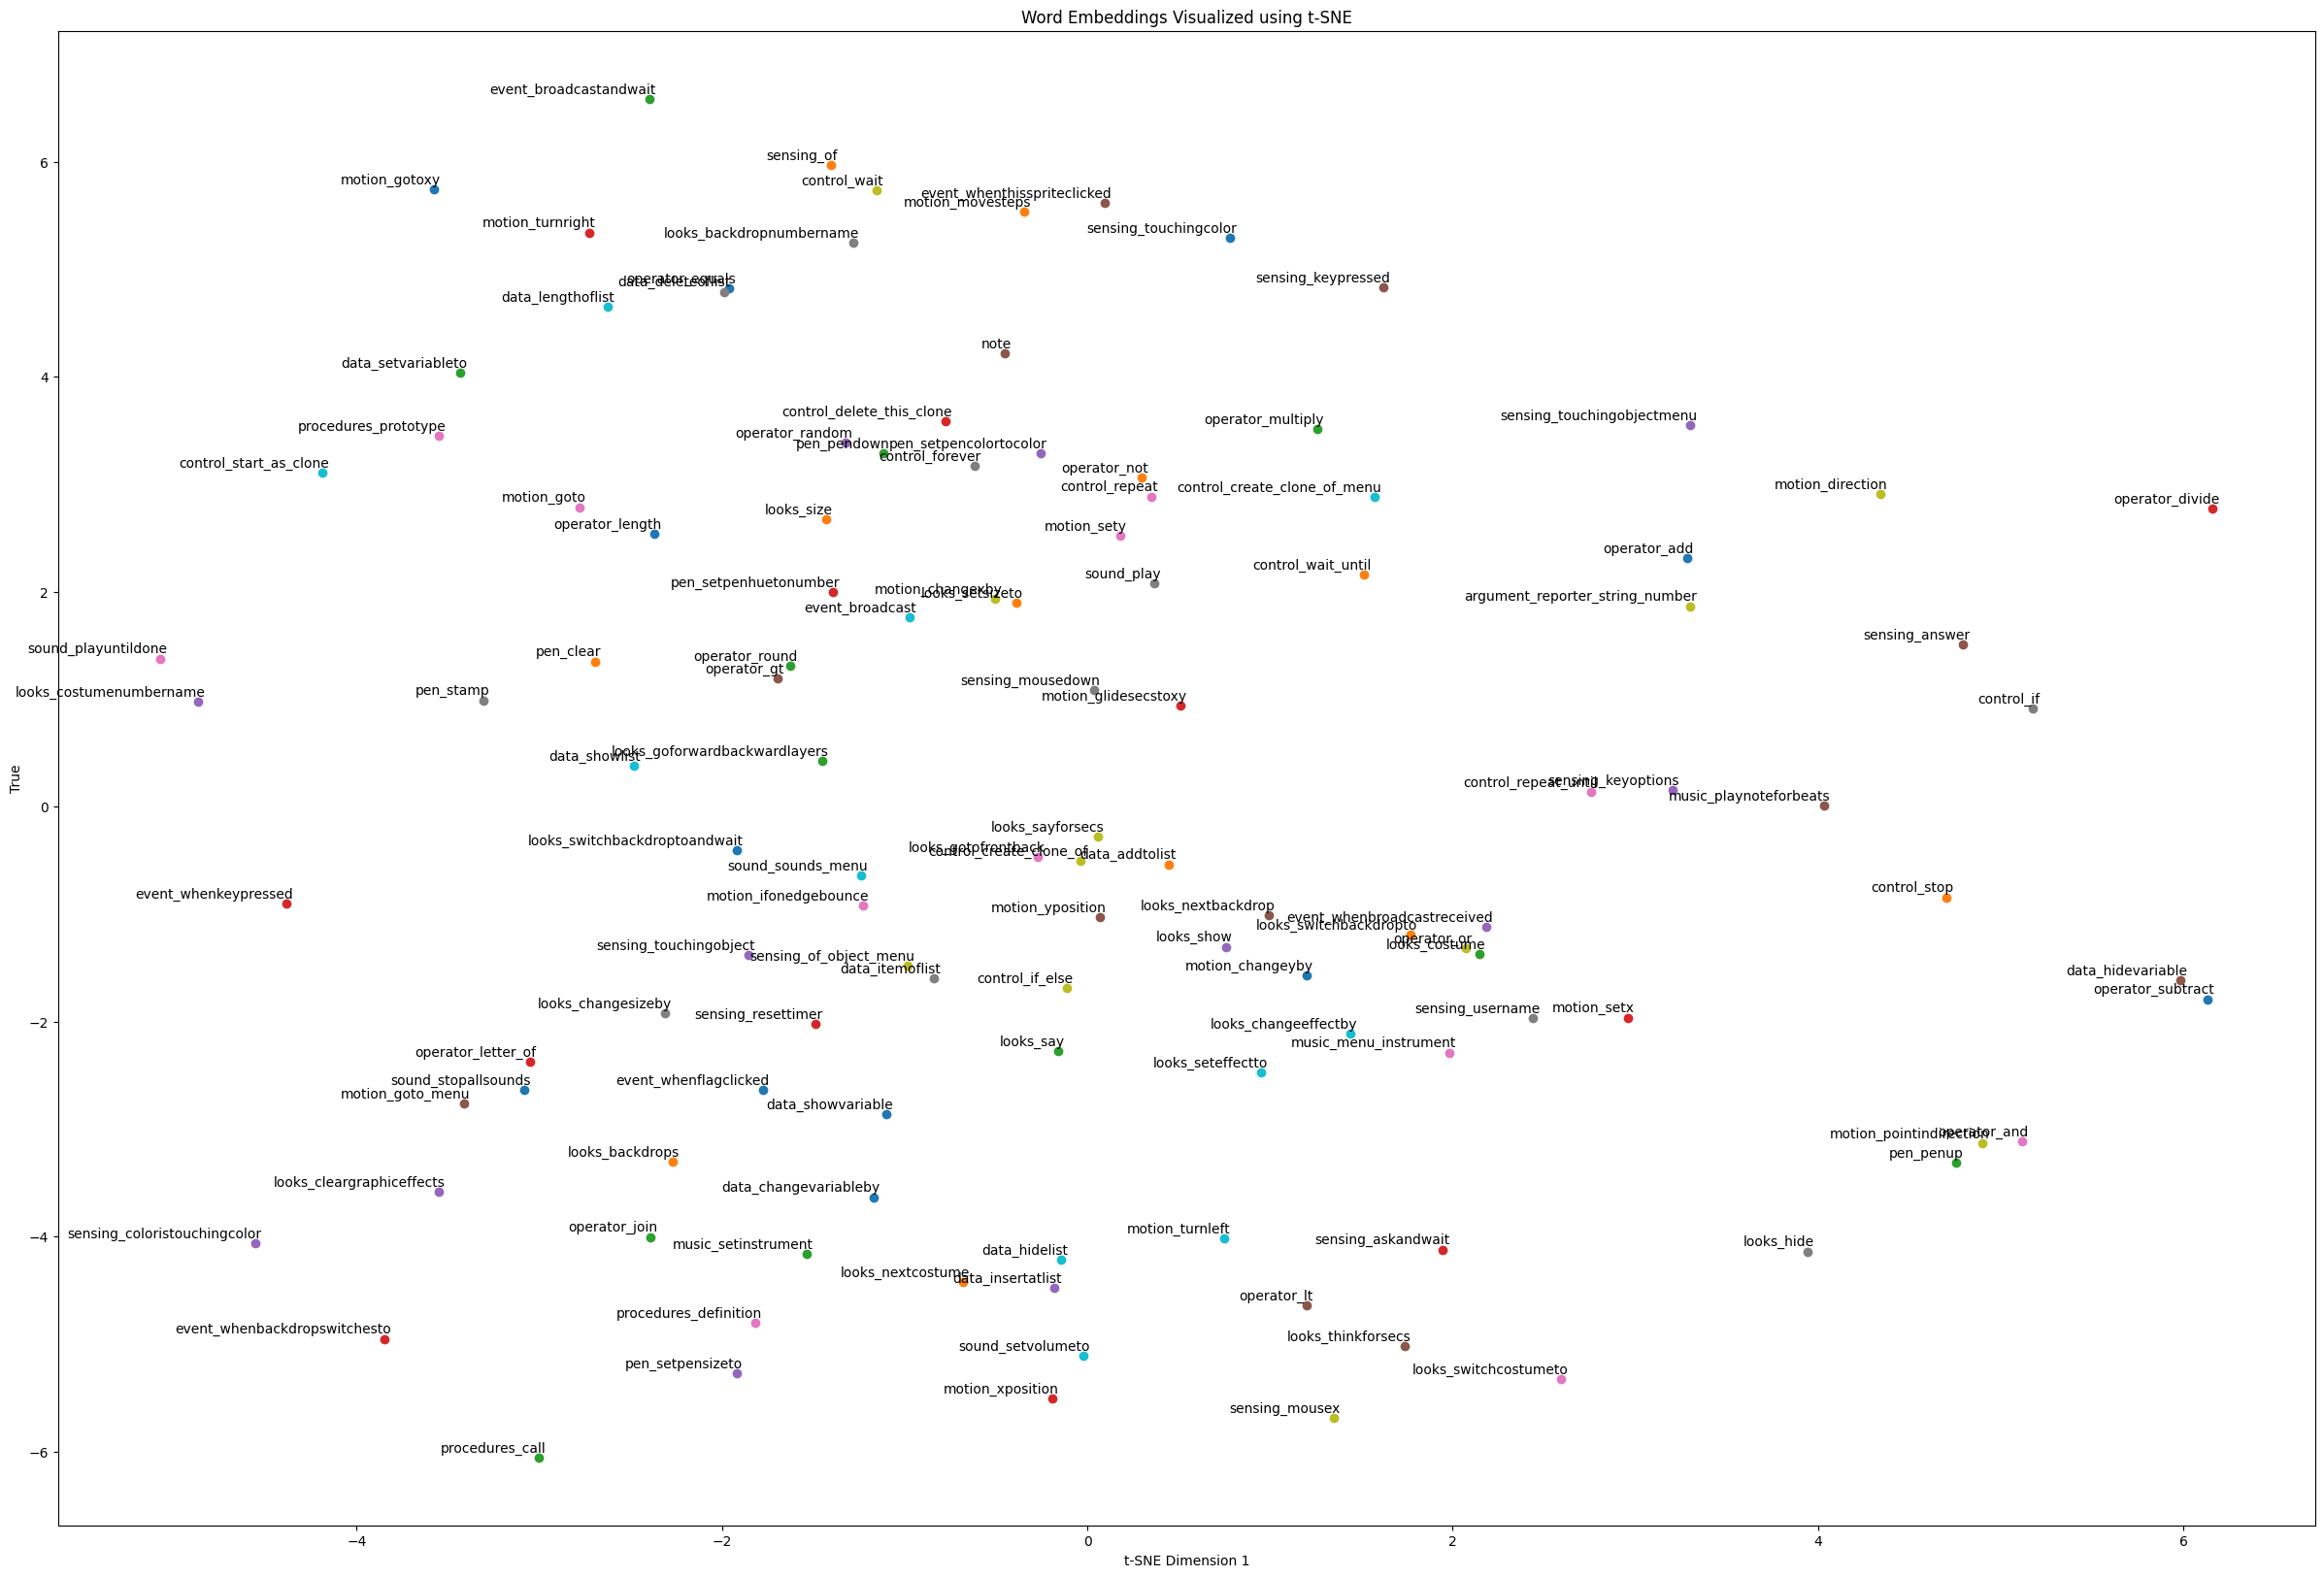

In [10]:
embeddings = model.embed_layer.weight.detach().cpu().numpy()
plot_embeddings(embeddings, dataset.word2idx)


## MODEL SAVING

In [11]:
# Save trained model
model_path = "embedding_action_pong.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, model_path)

In [10]:
print("Dispositivo del modelo:", next(model.parameters()).device)


Dispositivo del modelo: cuda:0


### Apply K-Means

In [18]:
# Configurar el número de clusters
n_clusters = 10

# Aplicar K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
labels = kmeans.labels_


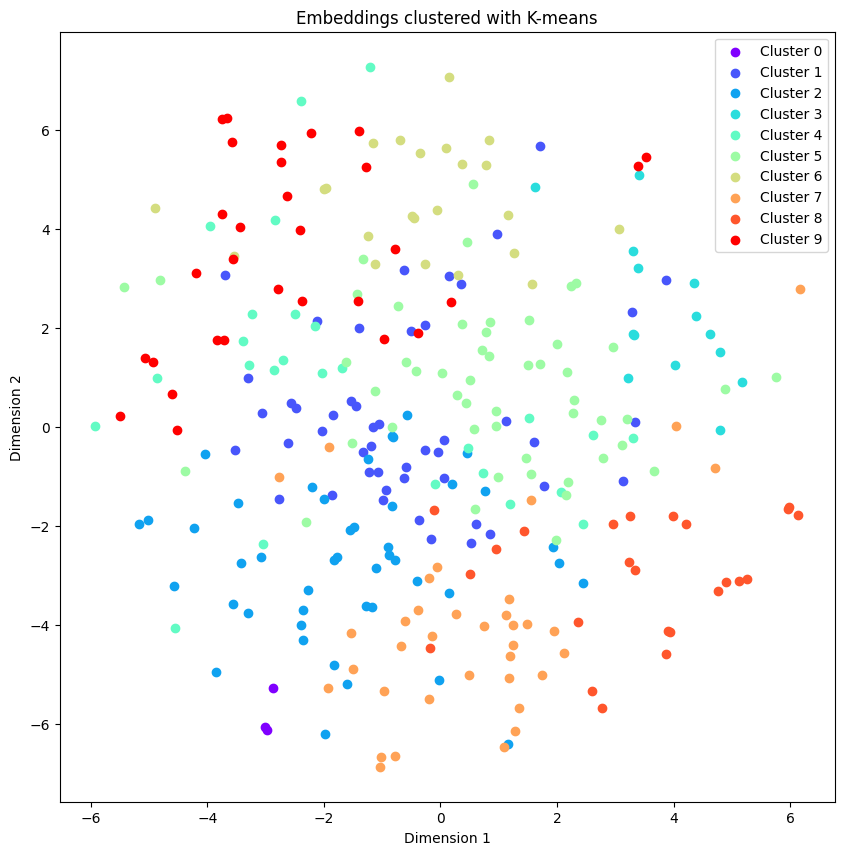

In [19]:
# Reducir los embeddings a 2D usando t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

# Crear un mapa de colores para los clusters
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

# Plotear los embeddings
plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    points = embeddings_2d[labels == i]
    plt.scatter(points[:, 0], points[:, 1], color=colors[i], label=f'Cluster {i}')
plt.legend()
plt.title('Embeddings clustered with K-means')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## K-Means and Embeddings Graph (NOT NECESSARY EXECUTE THE CODE ABOVE)

In [3]:
import matplotlib.cm as cm
print(embeddings)
def plot_embeddings(embeddings, word2idx, n_clusters=10):
    num_samples = len(word2idx)

    # Realizar K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
    labels = kmeans.labels_

    # Reducir dimensionalidad con t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(embeddings)

    # Crear un mapa de colores para los clusters
    colors = cm.rainbow(np.linspace(0, 1, n_clusters))

    plt.figure(figsize=(30, 20))
    
    # Dibujar los puntos con los colores de los clusters
    for i, (word, idx) in enumerate(word2idx.items()):
        cluster_id = labels[idx]
        plt.scatter(vectors[idx, 0], vectors[idx, 1], color=colors[cluster_id], label=f'Cluster {cluster_id}' if i == 0 else "")

    # Añadir anotaciones de las palabras
    for word, idx in word2idx.items():
        plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    
    plt.title('Word Embeddings Visualized using t-SNE and Clustered with K-means')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.savefig('embedding_action_pong.png', format='png')
    plt.show()
plot_embeddings(embeddings, dataset.word2idx)

NameError: name 'embeddings' is not defined